In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers

from scipy.stats import ttest_ind
from scipy.stats import norm
from scipy.spatial import distance

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder




# Active learning based reaction selection
* Uses an ensemble of models trained on the previous rounds of experiments to make predictions on all remaining possible reactions
* The mean and standard deviation of all predictions for a single reaction are calculated and used to calculate the Upper Confidence Bound (UCB) which is used to rank reactions to select the reactions most likely to give a better result
* To avoid oversampling similar reaction conditions, an iterative selection method was employed for each protein target. 
    * The reaction condition with the highest UCB score is selected
    * All reactions within a defined euclidean distance across all reaction parameters from the selected reaction are removed from the selection pool
    * The next reaction is chosen from the pool
    * Process continues until all reactions are selected 

In [2]:
dir_path = '../all_data/Figure_3_data/protein_id_comparison_models'
paths = [p for p in glob.glob(f'./{dir_path}/*') if '.keras' in p]
paths
model_dict = {}
for path in paths:
    print(path)
    model_num = int(path.split('\\')[-1].split('-')[-1].split('.')[0])
    current_model = keras.models.load_model(path)
    model_dict.update({model_num:current_model})
    
model_data = pd.read_pickle(glob.glob(f'./{dir_path}/*.pkl')[0])
model_data

./../all_data/Figure_3_data/protein_id_comparison_models\model-0.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-1.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-10.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-11.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-12.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-13.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-14.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-15.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-16.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-17.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-18.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-19.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-2.keras
./../all_data/Figure_3_data/protein_id_comparison_models\model-20.k

,fold,model_id,ensemble,loss,label_type,batch,learning_rate,nodes,cols,test_ids,train_ids
0,0,0,no_prot_features,mean_squared_error,label,10,0.001,"[128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid]","[2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....","[2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060...."
1,0,1,no_prot_features,mean_squared_error,label,10,0.001,"[256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid]","[2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....","[2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060...."
2,0,2,no_prot_features,mean_squared_error,label,10,0.001,"[512, 256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid]","[2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....","[2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060...."
3,0,3,no_prot_features,mean_squared_error,label,50,0.001,"[128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid]","[2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....","[2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060...."
4,0,4,no_prot_features,mean_squared_error,label,50,0.001,"[256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid]","[2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....","[2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060...."
...,...,...,...,...,...,...,...,...,...,...,...
85,4,85,dna_encoded,mean_squared_error,label,50,0.001,"[256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[1849.0, 475.0, 1020.0, 2984.0, 2342.0, 3851.0...","[2999.0, 2744.0, 2680.0, 3314.0, 1542.0, 2037...."
86,4,86,dna_encoded,mean_squared_error,label,50,0.001,"[512, 256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[1849.0, 475.0, 1020.0, 2984.0, 2342.0, 3851.0...","[2999.0, 2744.0, 2680.0, 3314.0, 1542.0, 2037...."
87,4,87,dna_encoded,mean_squared_error,label,200,0.001,"[128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[1849.0, 475.0, 1020.0, 2984.0, 2342.0, 3851.0...","[2999.0, 2744.0, 2680.0, 3314.0, 1542.0, 2037...."
88,4,88,dna_encoded,mean_squared_error,label,200,0.001,"[256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[1849.0, 475.0, 1020.0, 2984.0, 2342.0, 3851.0...","[2999.0, 2744.0, 2680.0, 3314.0, 1542.0, 2037...."


### Only use the ensemble with the DNA encoded features

In [3]:
model_data = model_data[model_data['ensemble'] == 'dna_encoded'].copy().reset_index(drop=True)
model_data


,fold,model_id,ensemble,loss,label_type,batch,learning_rate,nodes,cols,test_ids,train_ids
0,0,45,dna_encoded,mean_squared_error,label,10,0.001,"[128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....","[2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060...."
1,0,46,dna_encoded,mean_squared_error,label,10,0.001,"[256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....","[2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060...."
2,0,47,dna_encoded,mean_squared_error,label,10,0.001,"[512, 256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....","[2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060...."
3,0,48,dna_encoded,mean_squared_error,label,50,0.001,"[128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....","[2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060...."
4,0,49,dna_encoded,mean_squared_error,label,50,0.001,"[256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....","[2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060...."
5,0,50,dna_encoded,mean_squared_error,label,50,0.001,"[512, 256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....","[2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060...."
6,0,51,dna_encoded,mean_squared_error,label,200,0.001,"[128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....","[2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060...."
7,0,52,dna_encoded,mean_squared_error,label,200,0.001,"[256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....","[2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060...."
8,0,53,dna_encoded,mean_squared_error,label,200,0.001,"[512, 256, 128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2999.0, 1542.0, 2944.0, 2519.0, 2765.0, 2461....","[2744.0, 2680.0, 3314.0, 1849.0, 2037.0, 3060...."
9,1,54,dna_encoded,mean_squared_error,label,10,0.001,"[128, 64, 32, 16]","[Mg, SecYE, K, PEG, lipid, DNA_name-AqpZ, DNA_...","[2744.0, 2037.0, 532.0, 3320.0, 3064.0, 3200.0...","[2999.0, 2680.0, 3314.0, 1849.0, 1542.0, 3060...."


## Create a dataframe of all possible reaction conditions

In [3]:
combo_df = pd.read_excel('./possible_concentrations.xlsx')

# Group the reagent and its concentration into a single id
combo_df['list_combo'] = list(zip(combo_df.group,combo_df.reagent, combo_df.conc))
# Pulls out each reagent within the same group so that they are not combined together
combos = []
for reagent,df in combo_df.groupby('group'):
    combos.append(list(df['list_combo'].tolist()))
unique_rxns = list(itertools.product(*combos))
reagent_cols = [l[0] for l in unique_rxns[0][:]]
df = pd.DataFrame(unique_rxns,columns=reagent_cols)
df = df.stack().reset_index().rename(columns={'level_0':'rxn_id','level_2':'reagent',0:'all'})
df[['group','reagent','target']] = pd.DataFrame(df['all'].tolist(), index= df.index)
df = df.drop(columns=['all','level_1'])

all_cols = []
for group,group_df in df.groupby('group'):
    if len(group_df['reagent'].unique()) == 1:
        temp = group_df[['rxn_id','target']].rename(columns={'target':group})
        all_cols.append(temp.set_index('rxn_id'))
    else:
        temp = group_df[['rxn_id','reagent','target']]
        temp = temp.rename(columns={'reagent':f'{group}_name','target':f'{group}_conc'})
        all_cols.append(temp.set_index('rxn_id'))

key = pd.concat(all_cols,axis=1).reset_index()
lipo_dict = {'DOPC':18,'DPPC':16,'DMPC':14,'no_lipo':0}
key['lipid'] = key['Liposome_name'].apply(lambda x: lipo_dict[x])
key = key.drop(columns=['Liposome_name'])
key


,rxn_id,DNA_name,DNA_conc,K,Mg,PEG,SecYE,lipid
0,0,AqpZ,5,85,8,0,0,18
1,1,AqpZ,5,85,8,0,0.625,18
2,2,AqpZ,5,85,8,0,1.25,18
3,3,AqpZ,5,85,8,1,0,18
4,4,AqpZ,5,85,8,1,0.625,18
...,...,...,...,...,...,...,...,...
12091,12091,Vol,5,235,23,1,0.625,14
12092,12092,Vol,5,235,23,1,1.25,14
12093,12093,Vol,5,235,23,2,0,14
12094,12094,Vol,5,235,23,2,0.625,14


In [5]:
def add_one_hot(df,col_name):
    temp = df[[col_name]]

    one_hot_encoder = OneHotEncoder(sparse_output=False)
    one_hot_encoder.fit(temp)

    encoded = one_hot_encoder.transform(temp)
    encoded = pd.DataFrame(data=encoded, columns=[col_name+'-'+c for c in one_hot_encoder.categories_])
    df = df.join(encoded)
    targets = list([col_name+'-'+c for c in one_hot_encoder.categories_])[0]
    original = [(t,) for t in targets]
    df = df.rename(columns=dict(zip(original,targets)))
    return df


prot_feat = key[['DNA_name']].drop_duplicates().reset_index(drop=True)
dna_encoded = add_one_hot(prot_feat,'DNA_name')

key = key.set_index('DNA_name').join(dna_encoded.set_index('DNA_name')).reset_index()


# Fit and transform the columns using a min max scaler
scale_cols = ['Mg', 'SecYE', 'K', 'PEG','lipid']
data_bounded = key[scale_cols]
X_bounded = np.array(data_bounded)
MMscalerX = MinMaxScaler()
X_bounded = MMscalerX.fit_transform(X_bounded)
data_bounded = pd.DataFrame(X_bounded,columns=data_bounded.columns)
data_bounded['rxn_id'] = key['rxn_id']
data_bounded = data_bounded.drop_duplicates().set_index('rxn_id')
data_bounded

# # Add the one hot encoded DNA features to the data and remove the DNA_name column
all_features = data_bounded.join(key.drop(columns=scale_cols).set_index('rxn_id')).reset_index()
all_features

,rxn_id,Mg,SecYE,K,PEG,lipid,DNA_name,DNA_conc,Liposome_conc,DNA_name-AqpZ,...,DNA_name-Mol,DNA_name-MscL,DNA_name-MtlA,DNA_name-Neu,DNA_name-OR1A1,DNA_name-OR1D2,DNA_name-OR1E1,DNA_name-OR2AG1,DNA_name-SecYE-G,DNA_name-Vol
0,0,0.0,0.0,0.0,0.0,1.0,AqpZ,5.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,1.0,0.0,0.0,1.0,AqpZ,5.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.5,1.0,AqpZ,5.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,1.0,0.0,0.5,1.0,AqpZ,5.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,1.0,1.0,AqpZ,5.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3019,3019,1.0,1.0,1.0,0.0,0.0,Vol,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3020,3020,1.0,0.0,1.0,0.5,0.0,Vol,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3021,3021,1.0,1.0,1.0,0.5,0.0,Vol,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3022,3022,1.0,0.0,1.0,1.0,0.0,Vol,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [6]:
all_preds = []

for i,row in model_data.iterrows():
    temp = key.copy()
    target_data = np.array(all_features[row['cols']])
    preds = model_dict[row['model_id']].predict(target_data)
    temp['pred'] = preds
    temp['model_id'] = row['model_id']
    all_preds.append(temp)
    
all_preds = pd.concat(all_preds).reset_index(drop=True)
all_preds


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 84

,DNA_name,rxn_id,DNA_conc,K,Liposome_conc,Mg,PEG,SecYE,lipid,DNA_name-AqpZ,...,DNA_name-MtlA,DNA_name-Neu,DNA_name-OR1A1,DNA_name-OR1D2,DNA_name-OR1E1,DNA_name-OR2AG1,DNA_name-SecYE-G,DNA_name-Vol,pred,model_id
0,AqpZ,0,5.0,85.0,3.0,8.0,0.0,0.00,18,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.844616,45
1,AqpZ,1,5.0,85.0,3.0,8.0,0.0,1.25,18,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.763805,45
2,AqpZ,2,5.0,85.0,3.0,8.0,1.0,0.00,18,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.795001,45
3,AqpZ,3,5.0,85.0,3.0,8.0,1.0,1.25,18,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.954509,45
4,AqpZ,4,5.0,85.0,3.0,8.0,2.0,0.00,18,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.442024,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136075,Vol,3019,5.0,185.0,3.0,20.0,0.0,1.25,14,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.431204,89
136076,Vol,3020,5.0,185.0,3.0,20.0,1.0,0.00,14,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.041046,89
136077,Vol,3021,5.0,185.0,3.0,20.0,1.0,1.25,14,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.364638,89
136078,Vol,3022,5.0,185.0,3.0,20.0,2.0,0.00,14,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.340531,89


In [7]:
means = all_preds.groupby('rxn_id').agg({'pred':'mean'}).reset_index()
stdevs = all_preds.groupby('rxn_id').agg({'pred':'std'}).reset_index()
means['stdev'] = stdevs['pred']
means = means.rename(columns={'pred':'mean'})
calcs = means.copy()
calcs = calcs.set_index('rxn_id').join(all_preds[scale_cols+['rxn_id','DNA_name']].set_index('rxn_id')).reset_index()
calcs['ucb'] = calcs['mean'] - (1*calcs['stdev'])
calcs = calcs.drop_duplicates().reset_index(drop=True)
calcs


,rxn_id,mean,stdev,Mg,SecYE,K,PEG,lipid,DNA_name,ucb
0,0,0.846780,0.263179,8.0,0.00,85.0,0.0,18,AqpZ,0.583600
1,1,0.988998,0.224691,8.0,1.25,85.0,0.0,18,AqpZ,0.764307
2,2,0.929878,0.274484,8.0,0.00,85.0,1.0,18,AqpZ,0.655394
3,3,0.891016,0.442490,8.0,1.25,85.0,1.0,18,AqpZ,0.448526
4,4,0.322181,0.126126,8.0,0.00,85.0,2.0,18,AqpZ,0.196055
...,...,...,...,...,...,...,...,...,...,...
3019,3019,-0.628045,0.365272,20.0,1.25,185.0,0.0,14,Vol,-0.993317
3020,3020,-0.142526,0.413928,20.0,0.00,185.0,1.0,14,Vol,-0.556454
3021,3021,-0.677534,0.389890,20.0,1.25,185.0,1.0,14,Vol,-1.067424
3022,3022,-0.288019,0.271006,20.0,0.00,185.0,2.0,14,Vol,-0.559025


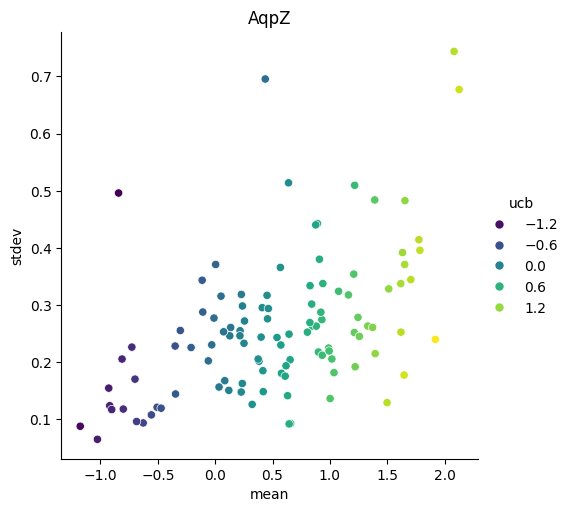

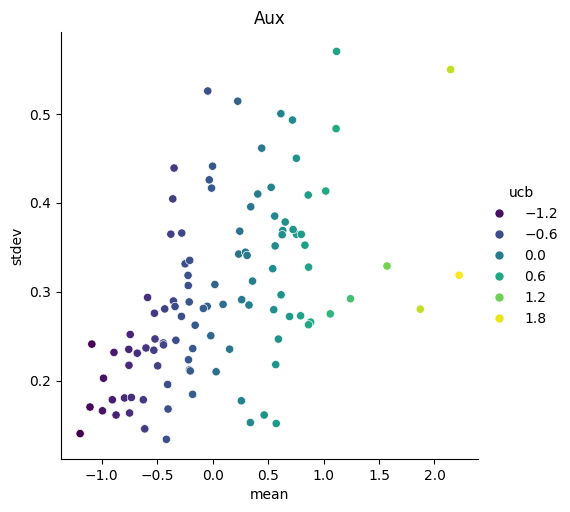

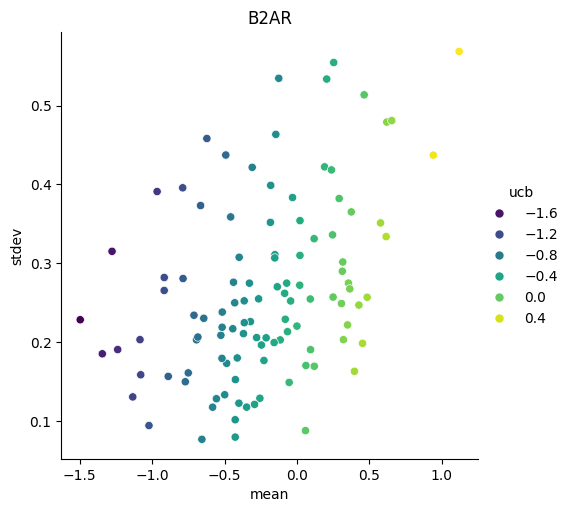

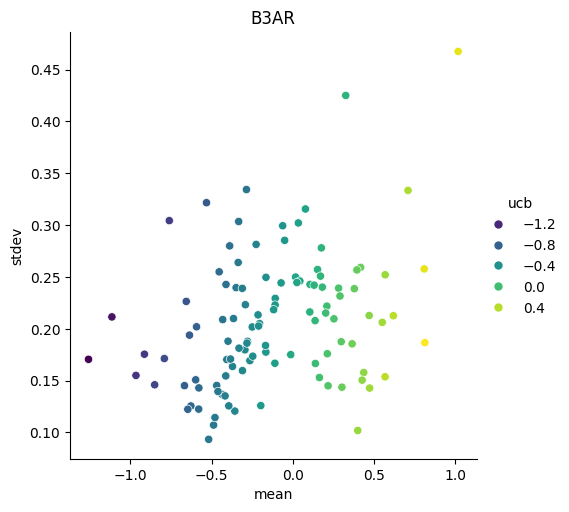

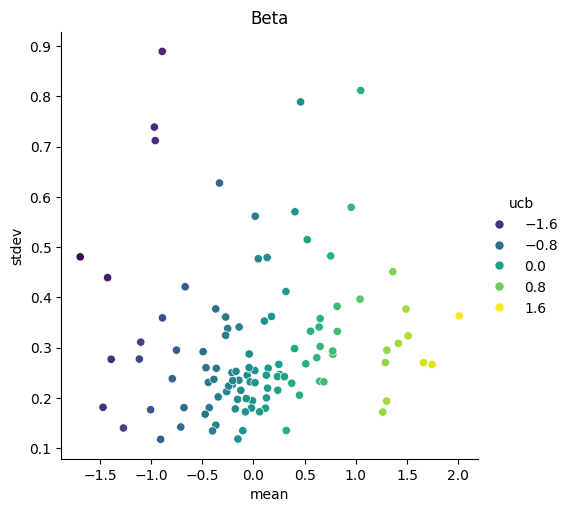

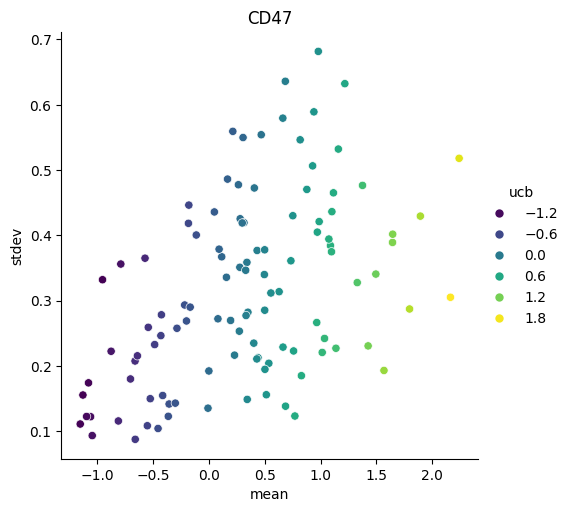

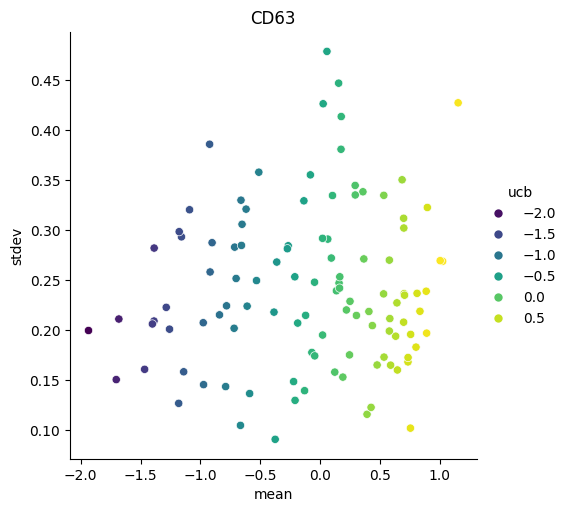

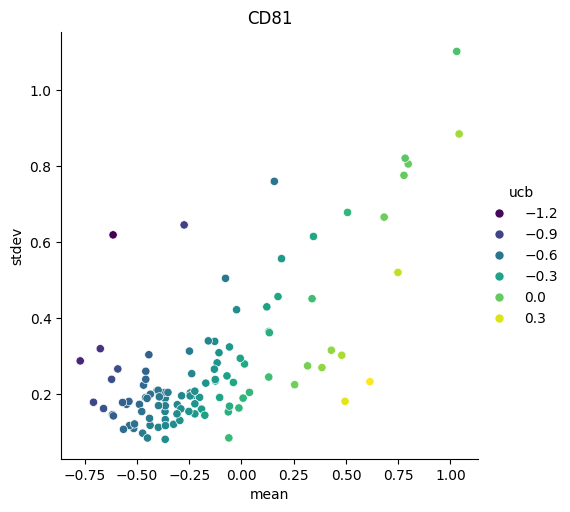

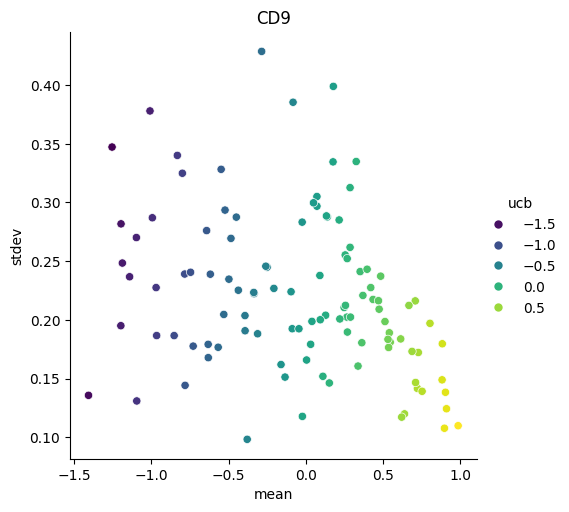

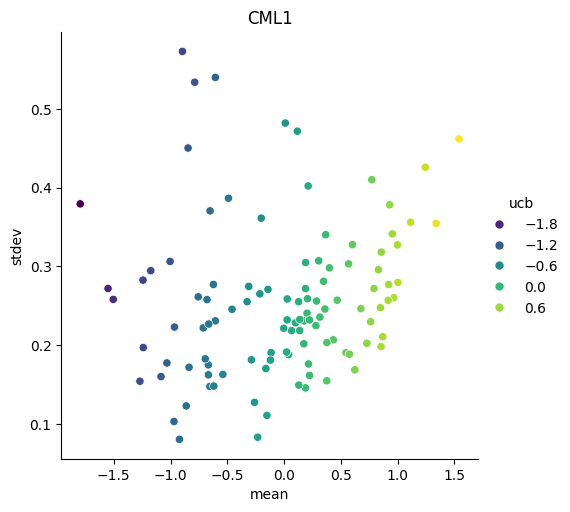

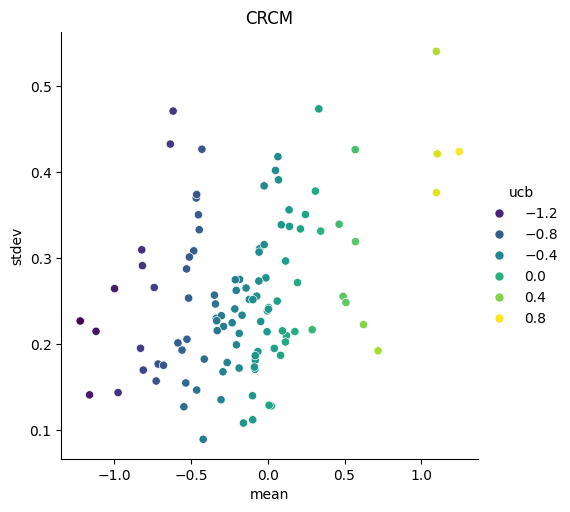

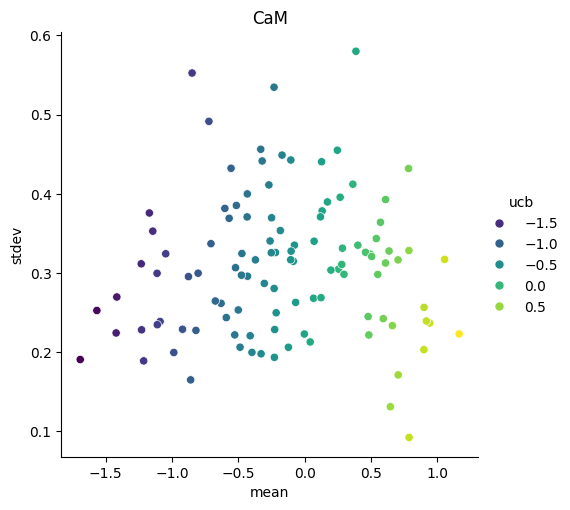

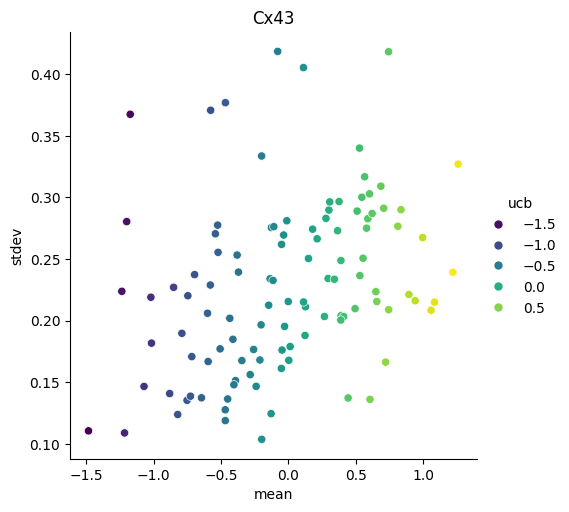

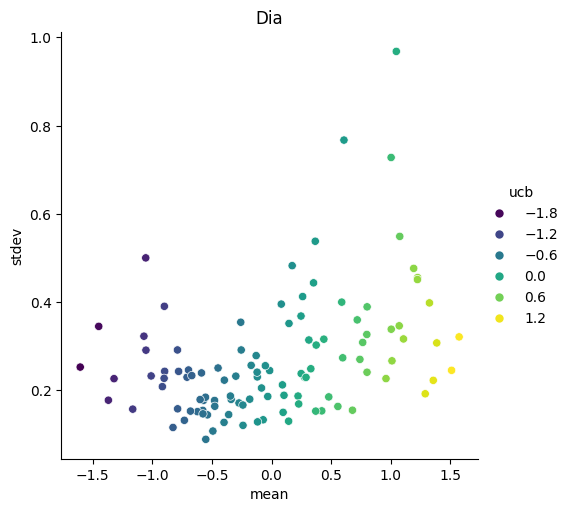

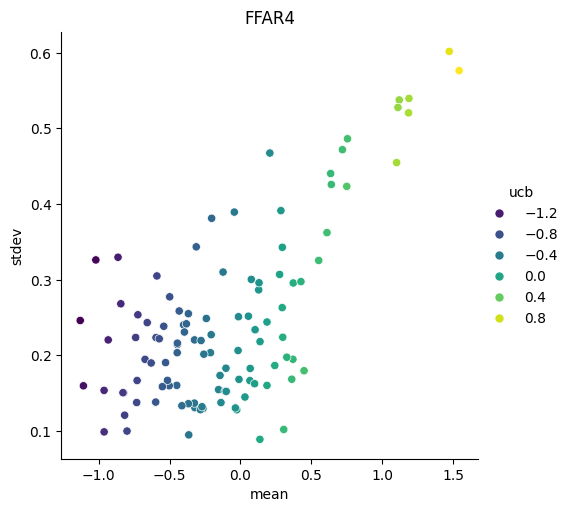

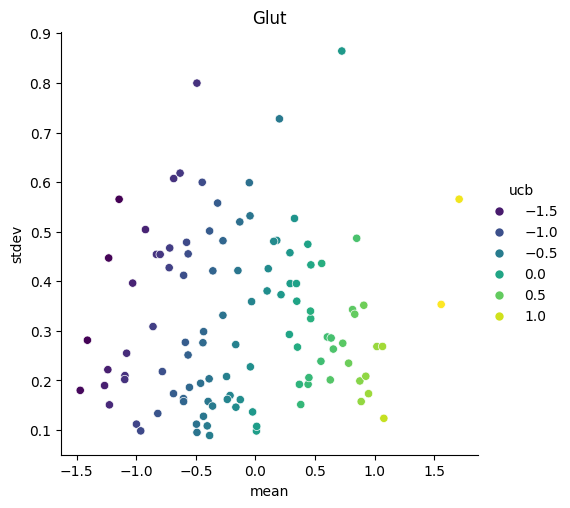

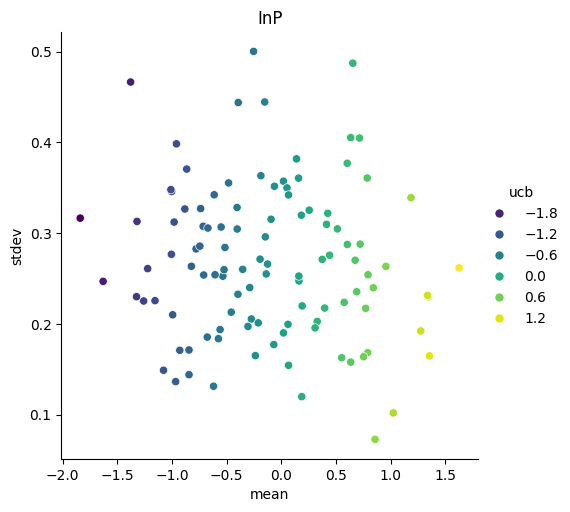

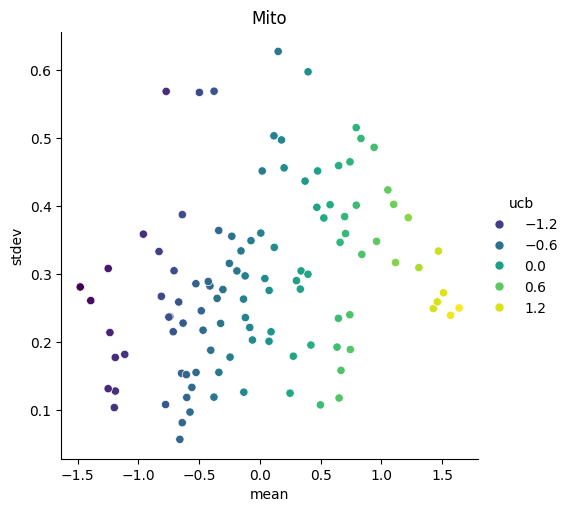

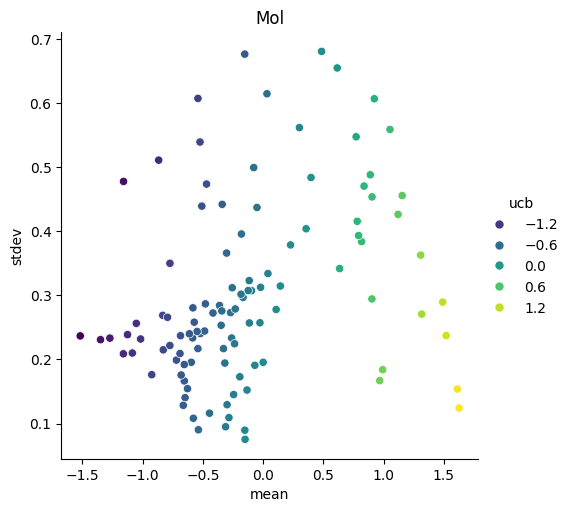

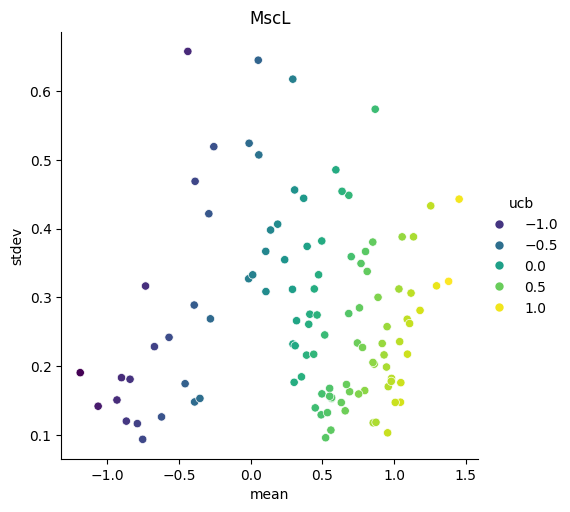

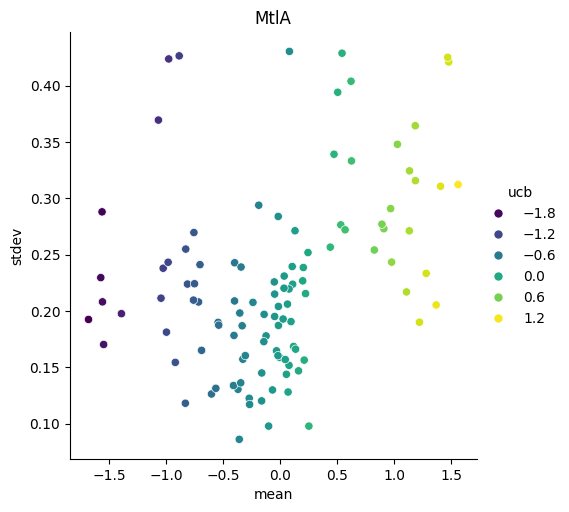

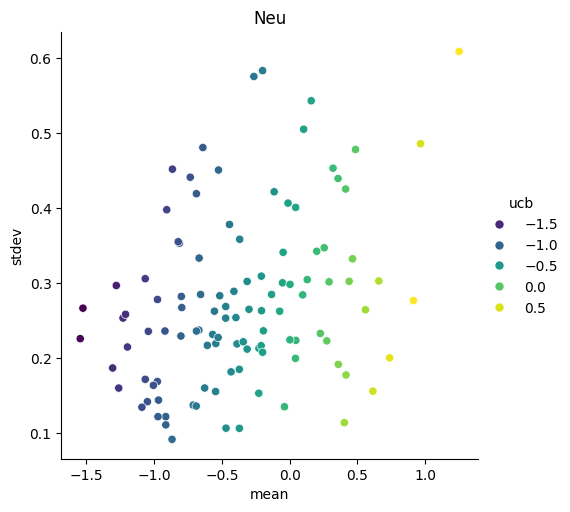

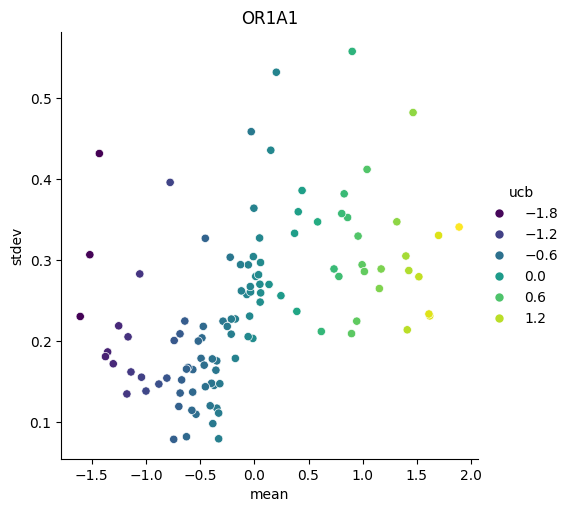

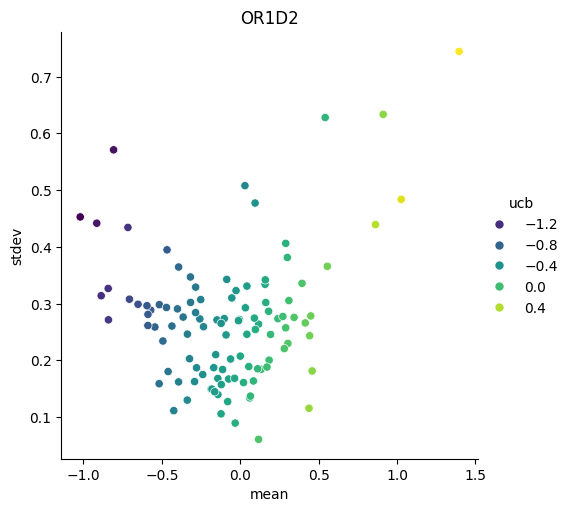

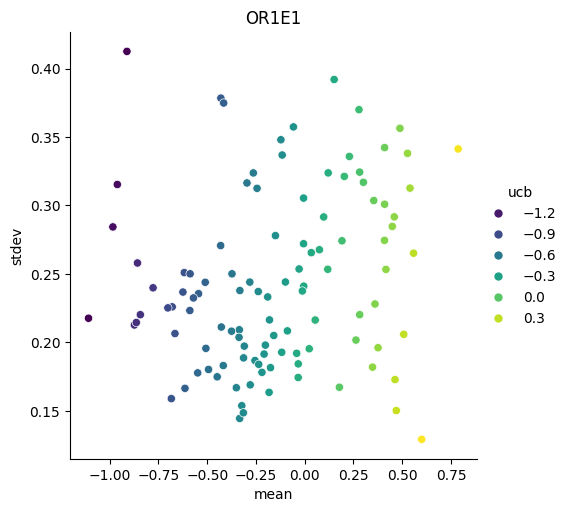

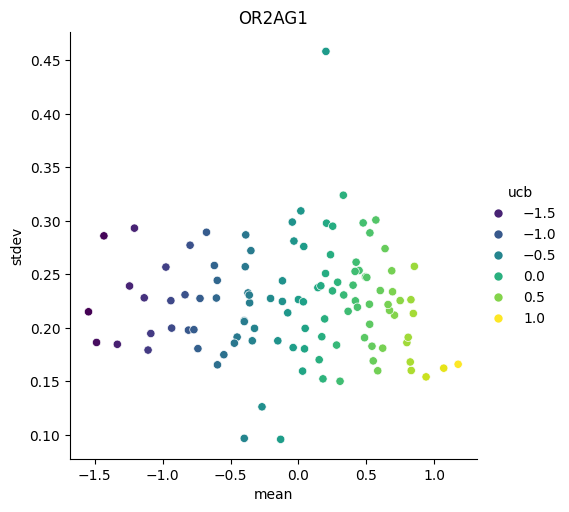

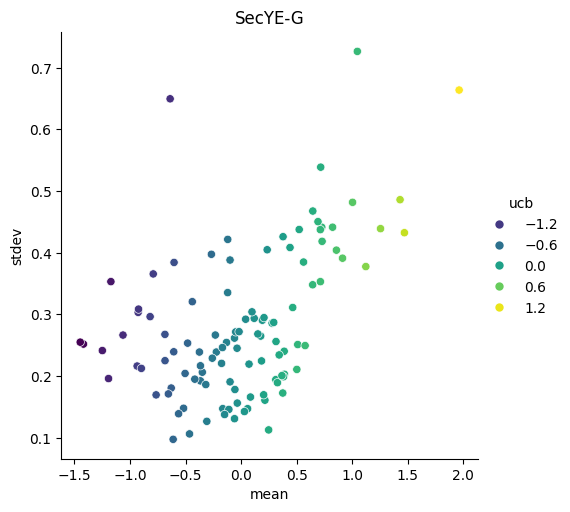

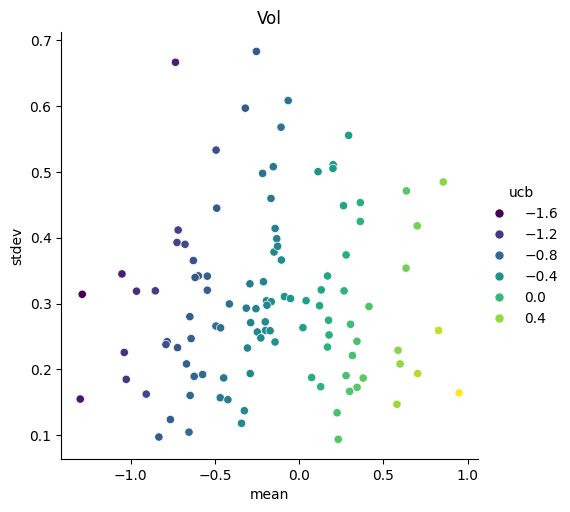

In [ ]:
for dna,dna_df in calcs.groupby('DNA_name'):
    sns.relplot(data=dna_df,x='mean',y='stdev',hue='ucb',palette='viridis')
    plt.title(dna)
    plt.show()

## Below is an illustrative example of the selection process

Round:  0


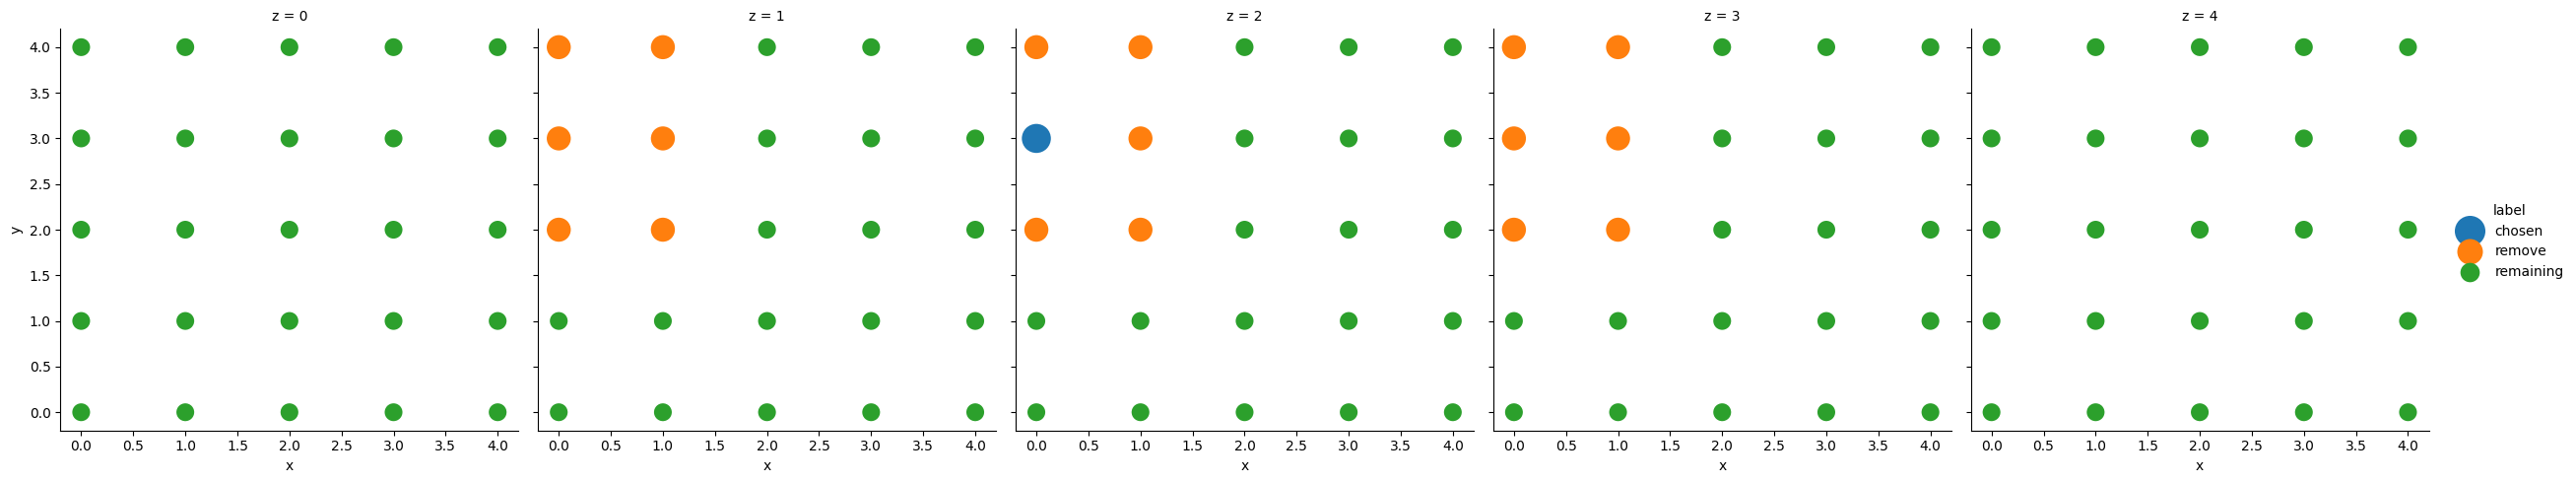

Round:  1


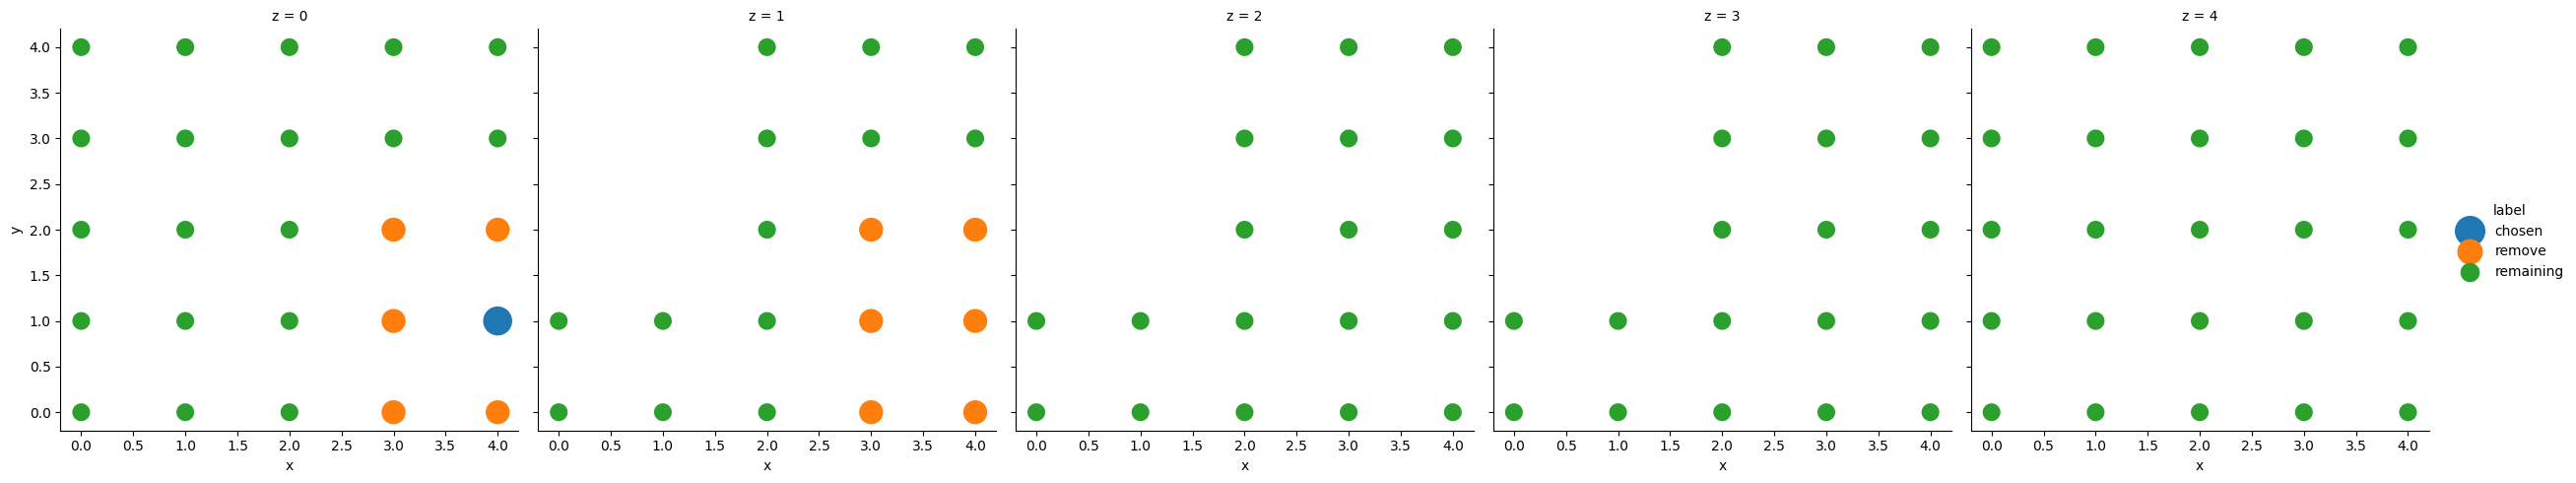

Round:  2


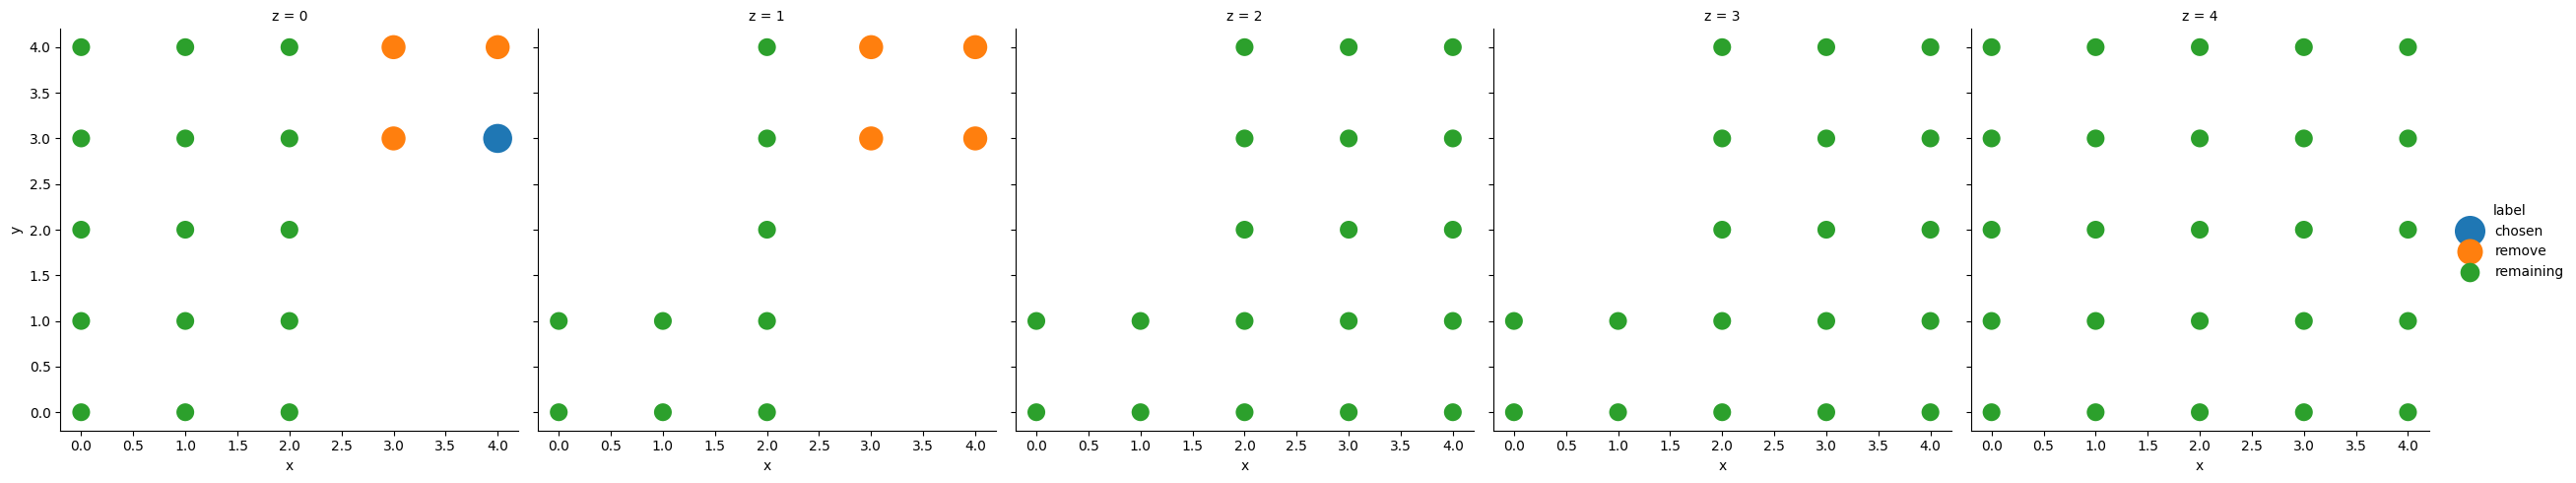

Round:  3


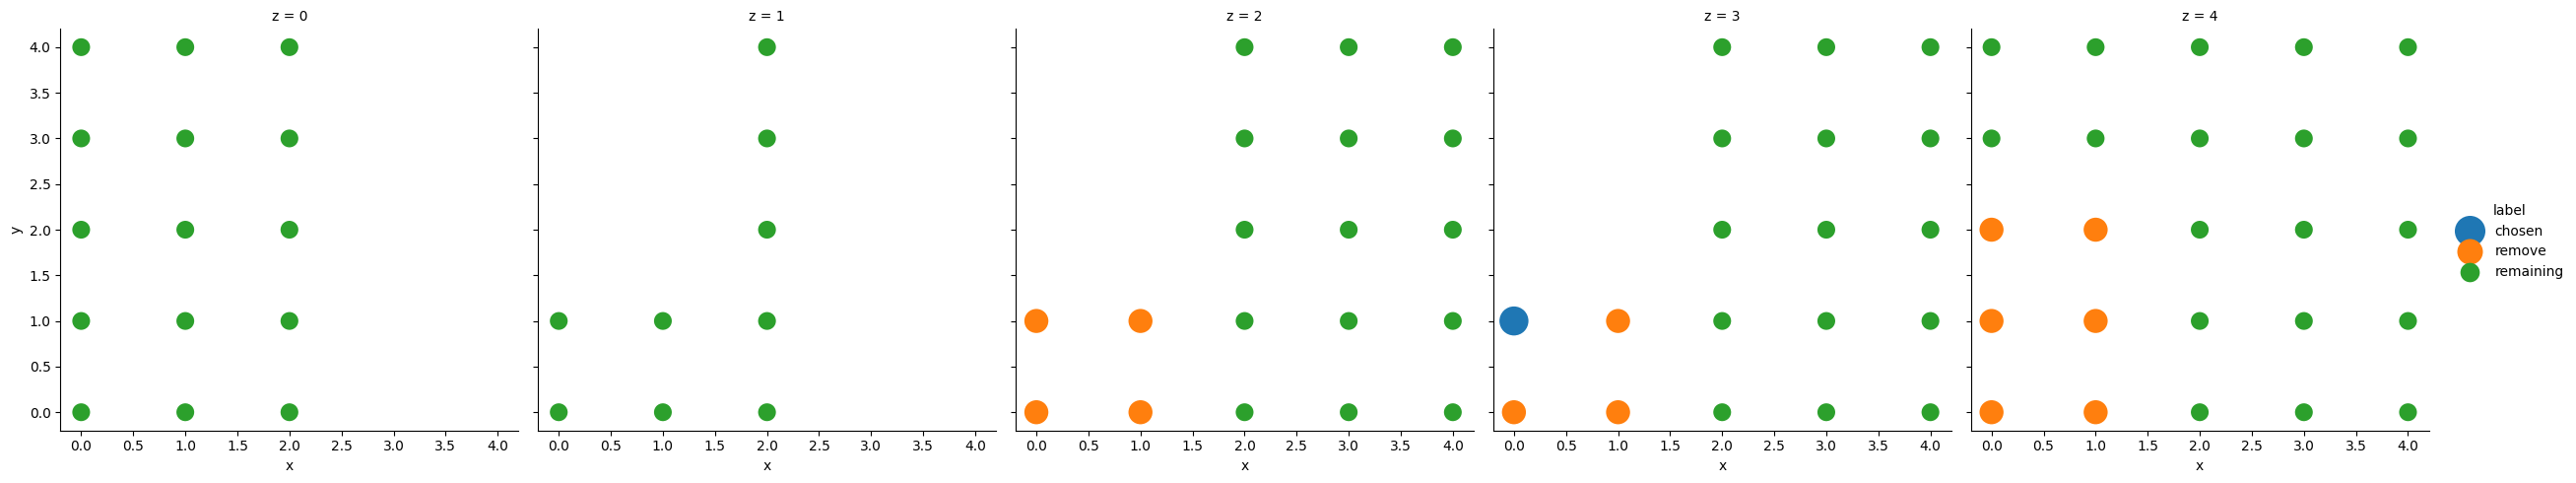

Round:  4


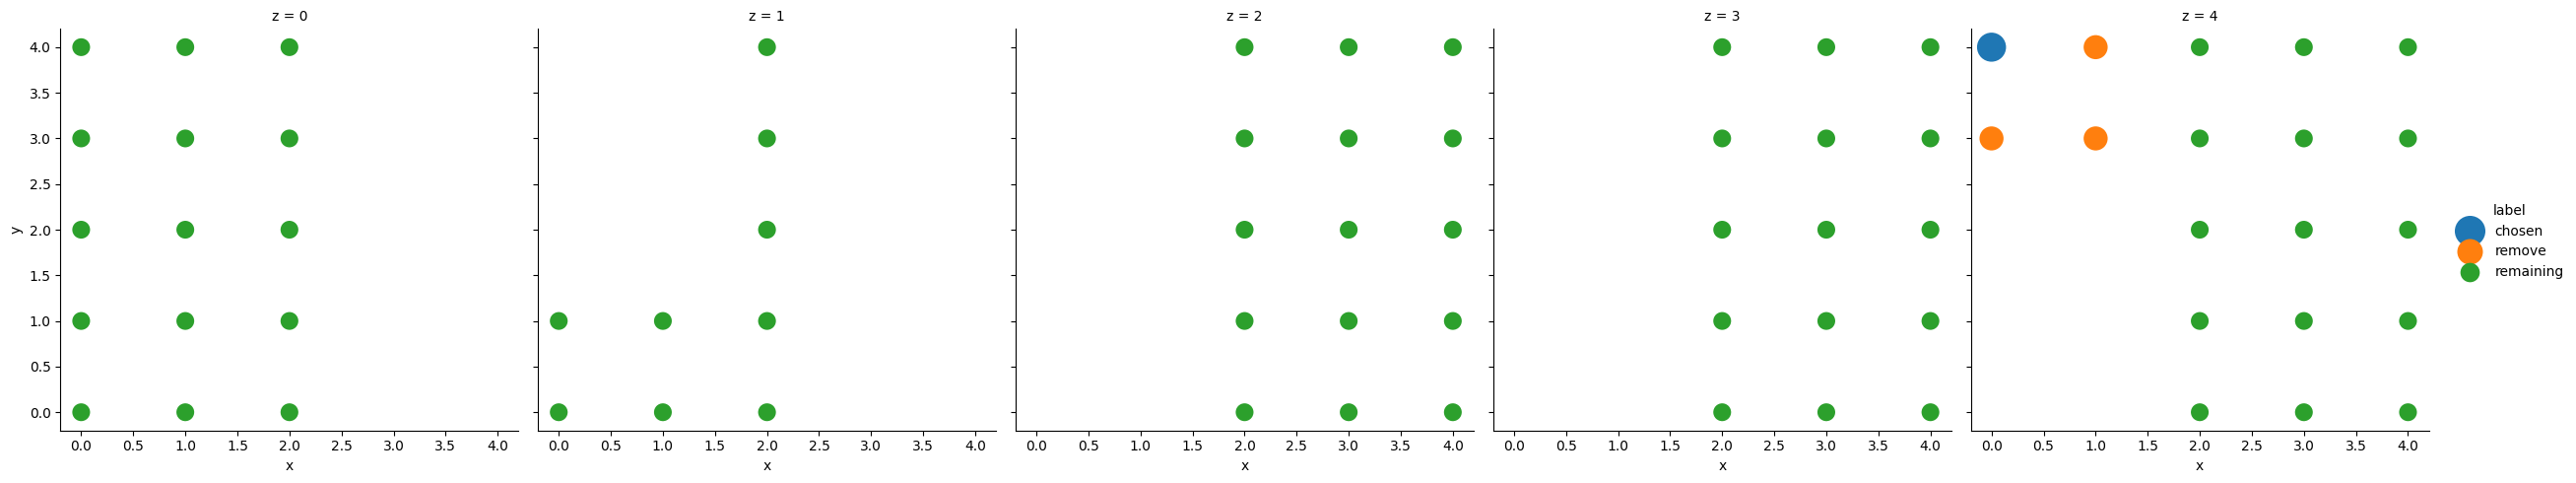

Round:  5


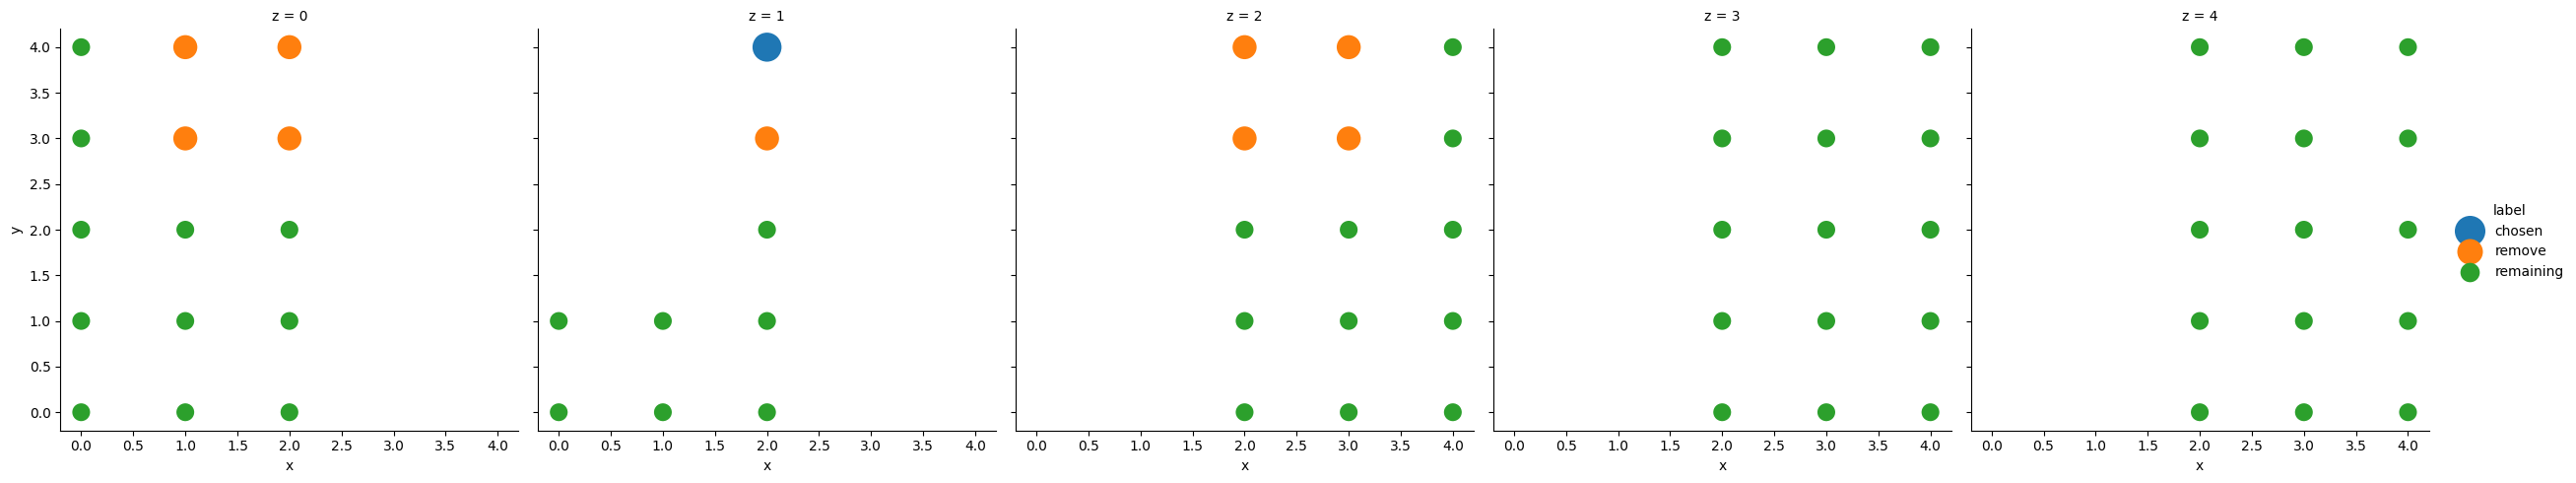

,x_dest,y_dest,z_dest
0,0,3,2
0,4,1,0
0,4,3,0
0,0,1,3
0,0,4,4
0,2,4,1


In [8]:
def assign_chosen(rxn_id):
    if rxn_id == chosen:
        return 'chosen'
    else:
        return 'possible'
    
def assign_label(dist):
    if dist == 0:
        return 'chosen'
    elif dist < threshold:
        return 'remove'
    else:
        return 'remaining'
    
def calc_dist(row):
    return distance.euclidean(row[exp_vars], row[new_cols])

test = pd.DataFrame(list(itertools.product(*[range(0,5),range(0,5),range(0,5)])),columns=['x','y','z'])
test = test.reset_index().rename(columns={'index':'rxn_id'})

num_select = 6
threshold = 2
test_rxns = []

for i in range(num_select):
    print('Round: ',i)

    chosen = random.sample(list(test['rxn_id']),1)[0]
    test['selection'] = test['rxn_id'].apply(assign_chosen)
    chosen_df = test[test['selection'] == 'chosen'].reset_index(drop=True)

    exp_vars = ['x','y','z']
    new_cols = [v+'_dest' for v in exp_vars]

    chosen_df = chosen_df[exp_vars]
    chosen_df = chosen_df.rename(columns=dict(zip(exp_vars,new_cols)))
    test_rxns.append(chosen_df)
    
    test = pd.concat([test,chosen_df],axis=1).ffill()
    test['dist'] = test.apply(calc_dist,axis=1)
    test['label'] = test['dist'].apply(assign_label)
    sns.relplot(data=test,x='x',y='y',col='z',hue='label',size='label',sizes=(200,500),size_order=['chosen','remove','remaining'],hue_order=['chosen','remove','remaining'])

    plt.show()
    
    test = test[test['label'] == 'remaining'].copy()
    test = test[['rxn_id']+exp_vars].reset_index(drop=True)
test_rxns = pd.concat(test_rxns)
test_rxns

## Reaction selection method

In [9]:
def calc_dist(row):
    return distance.euclidean(row[exp_vars], row[dest_cols])

def assign_label(dist):
    if dist == 0:
        return 'chosen'
    elif dist < threshold:
        return 'remove'
    else:
        return 'remaining'

exp_vars = ['Mg', 'SecYE', 'K', 'PEG','lipid']
dest_cols = [v+'_dest' for v in exp_vars]

num_select = 8
threshold = 0.75
chosen_rxns = []

temp = calcs.drop(columns='rxn_id').copy()
for dna, dna_df in temp.groupby('DNA_name'):
    print('\nDNA: ',dna)
    current = dna_df.reset_index().rename(columns={'index':'rxn_id'}).copy()

    scalerX = MinMaxScaler()
    X_bounded = scalerX.fit_transform(current[exp_vars])
    data_bounded = pd.DataFrame(X_bounded,columns=exp_vars)
    current = pd.concat([current[['rxn_id','ucb']],data_bounded],axis=1)
    current['label'] = 'remaining'
    for i in range(num_select):
        print('Round: ',i,' - Possible: ',len(current))
        chosen_id = current['ucb'].idxmax()
        current.at[chosen_id, 'label'] = 'chosen'
        chosen_df = current[current['label'] == 'chosen'].reset_index(drop=True)
        chosen_df['DNA_name'] = dna
        chosen_rxns.append(chosen_df)

        chosen_df = chosen_df[exp_vars]
        chosen_df = chosen_df.rename(columns=dict(zip(exp_vars,dest_cols)))

        current = pd.concat([current,chosen_df],axis=1).ffill()
        current['dist'] = current.apply(calc_dist,axis=1)
        current['label'] = current['dist'].apply(assign_label)

        current = current[current['label'] == 'remaining'].copy()
        current = current[['rxn_id','ucb']+exp_vars].reset_index(drop=True)
chosen_rxns = pd.concat(chosen_rxns)
chosen_rxns


DNA:  AqpZ
Round:  0  - Possible:  108
Round:  1  - Possible:  98
Round:  2  - Possible:  91
Round:  3  - Possible:  81
Round:  4  - Possible:  75
Round:  5  - Possible:  70
Round:  6  - Possible:  60
Round:  7  - Possible:  50

DNA:  Aux
Round:  0  - Possible:  108
Round:  1  - Possible:  101
Round:  2  - Possible:  87
Round:  3  - Possible:  74
Round:  4  - Possible:  64
Round:  5  - Possible:  63
Round:  6  - Possible:  62
Round:  7  - Possible:  61

DNA:  B2AR
Round:  0  - Possible:  108
Round:  1  - Possible:  101
Round:  2  - Possible:  94
Round:  3  - Possible:  90
Round:  4  - Possible:  86
Round:  5  - Possible:  74
Round:  6  - Possible:  70
Round:  7  - Possible:  67

DNA:  B3AR
Round:  0  - Possible:  108
Round:  1  - Possible:  98
Round:  2  - Possible:  91
Round:  3  - Possible:  77
Round:  4  - Possible:  69
Round:  5  - Possible:  64
Round:  6  - Possible:  61
Round:  7  - Possible:  51

DNA:  Beta
Round:  0  - Possible:  108
Round:  1  - Possible:  94
Round:  2  - Pos

,rxn_id,ucb,Mg,SecYE,K,PEG,lipid,label,DNA_name
0,24,1.678881,0.5,0.0,0.0,0.0,0.0,chosen,AqpZ
0,12,1.449152,1.0,0.0,0.0,0.0,1.0,chosen,AqpZ
0,7,1.369229,0.5,1.0,0.0,0.0,1.0,chosen,AqpZ
0,96,1.366812,0.5,0.0,1.0,0.0,0.0,chosen,AqpZ
0,56,1.067137,0.0,0.0,0.5,0.5,0.0,chosen,AqpZ
...,...,...,...,...,...,...,...,...,...
0,2922,0.165896,0.5,0.0,0.0,0.0,1.0,chosen,Vol
0,2957,0.132964,0.0,1.0,0.5,1.0,1.0,chosen,Vol
0,2932,-0.045747,1.0,0.0,0.0,1.0,1.0,chosen,Vol
0,2998,-0.113433,0.5,0.0,1.0,1.0,1.0,chosen,Vol


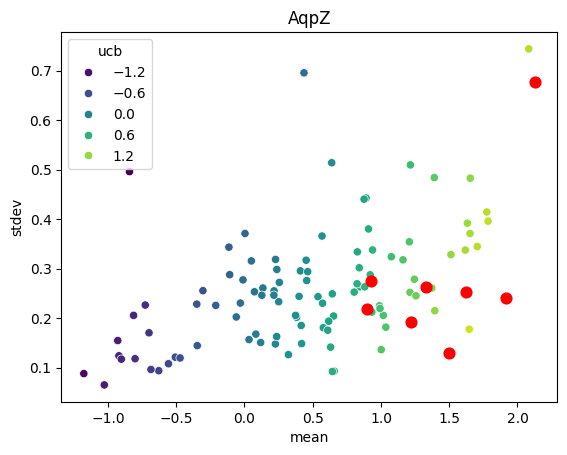

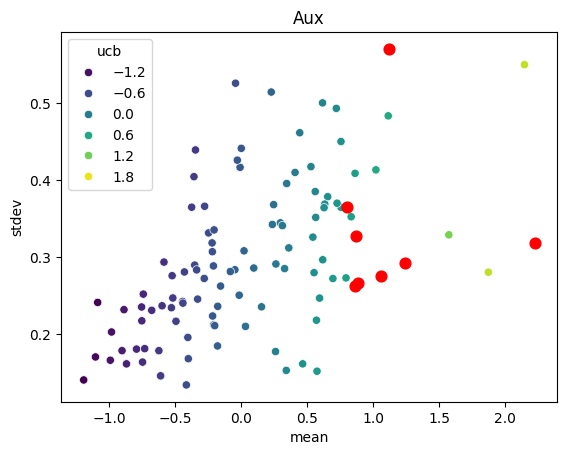

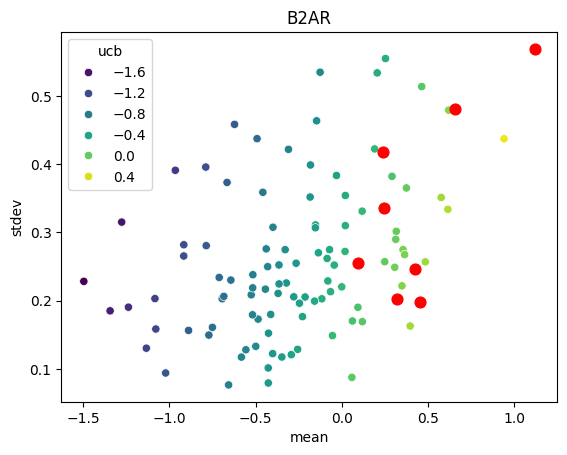

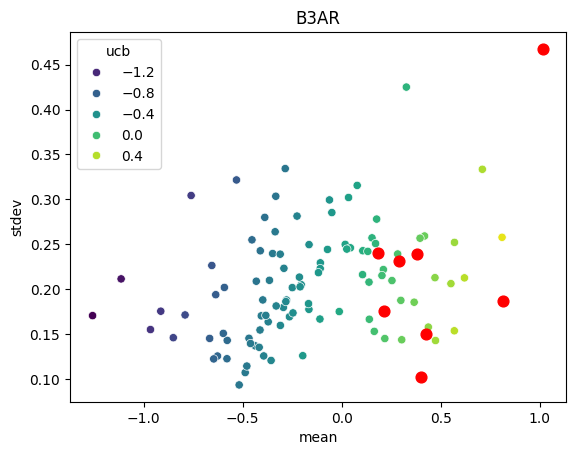

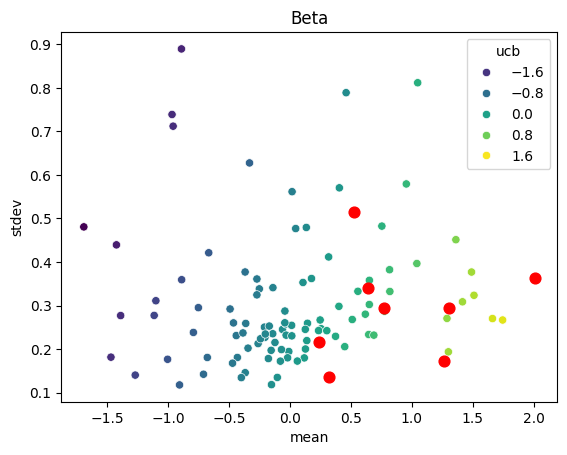

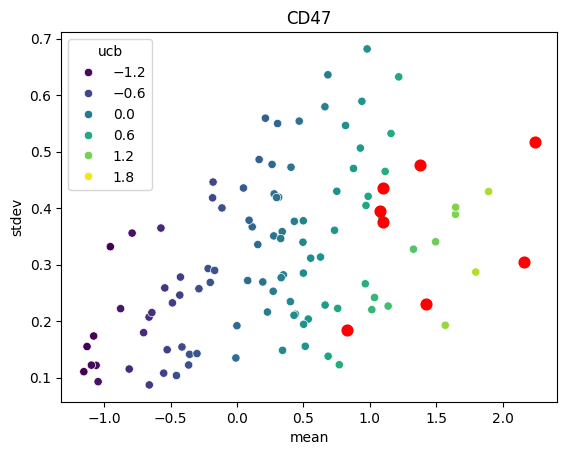

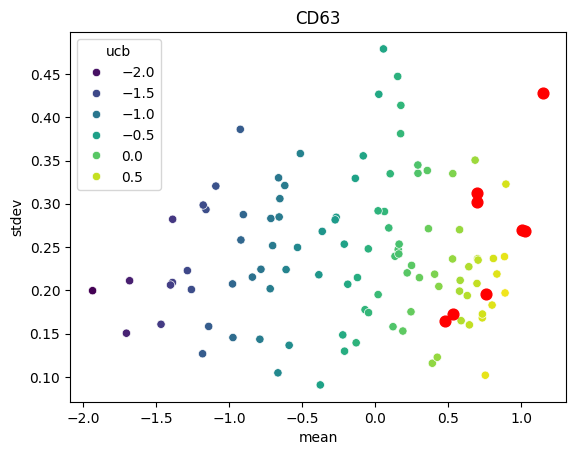

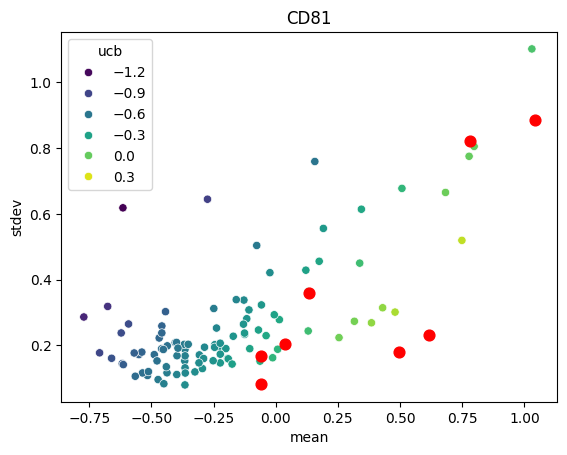

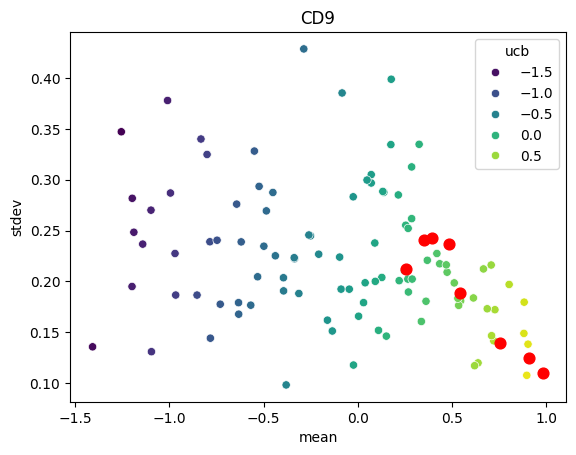

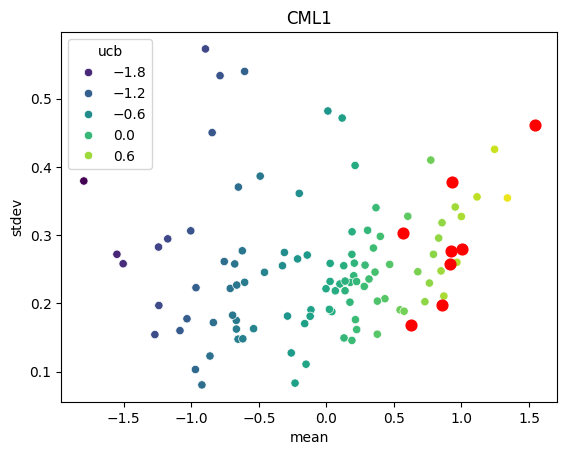

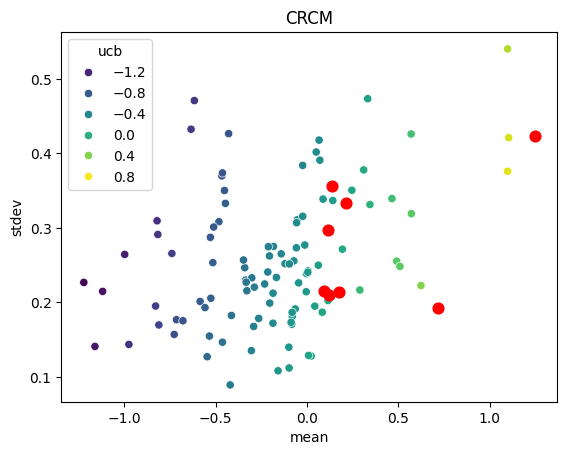

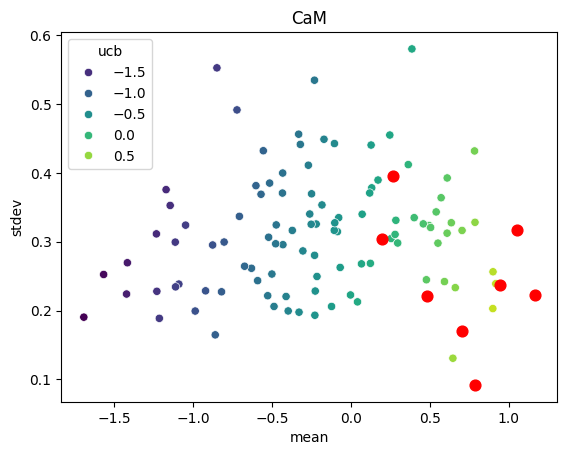

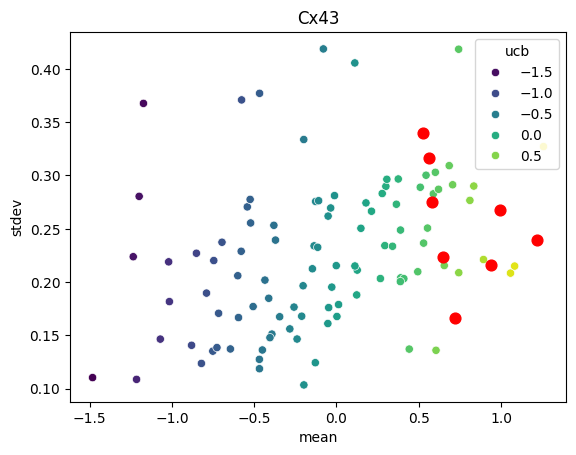

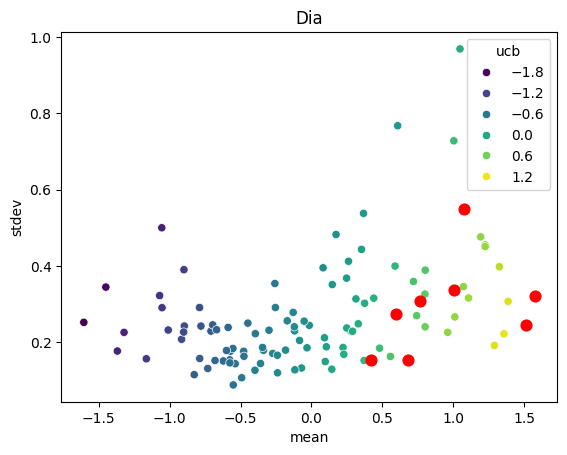

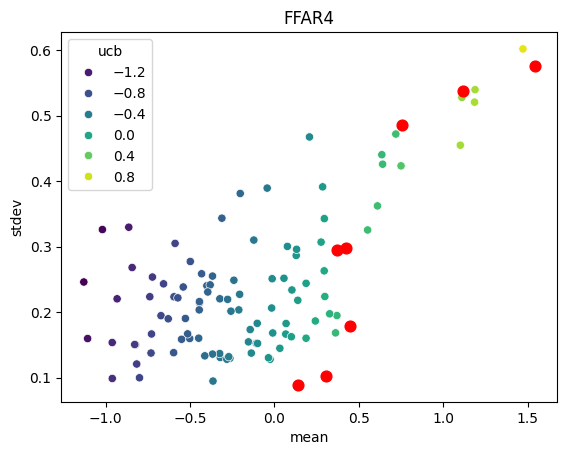

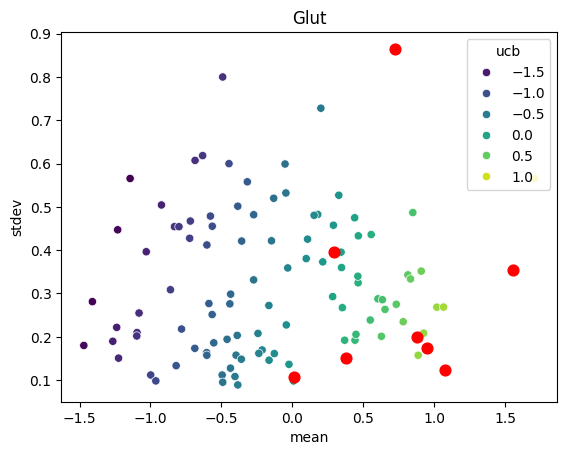

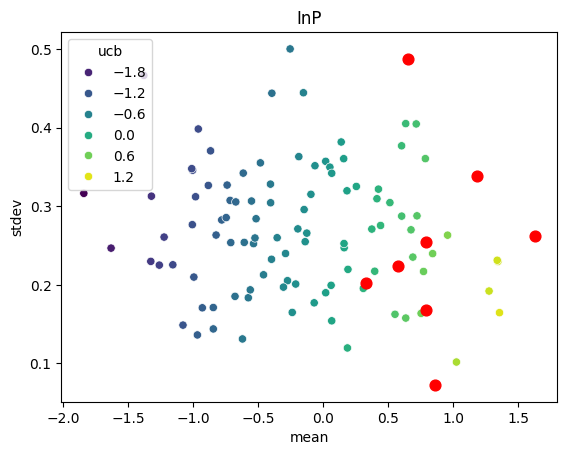

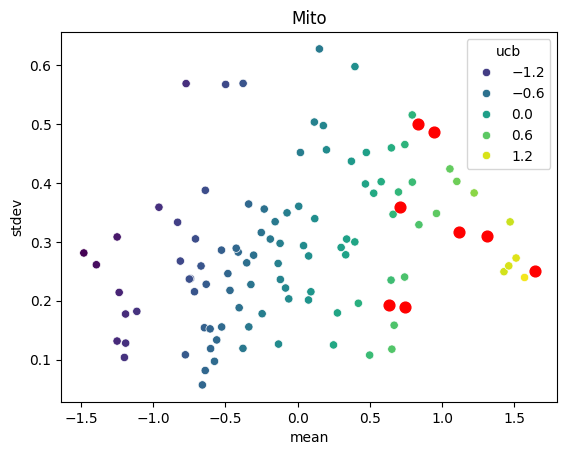

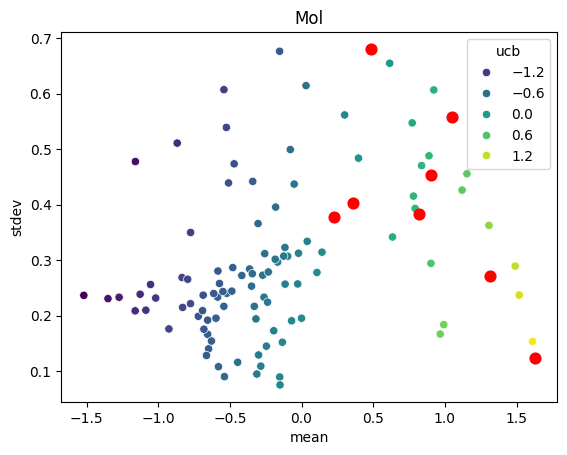

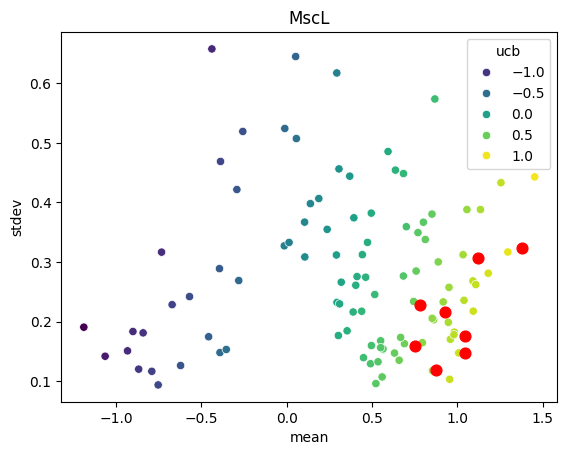

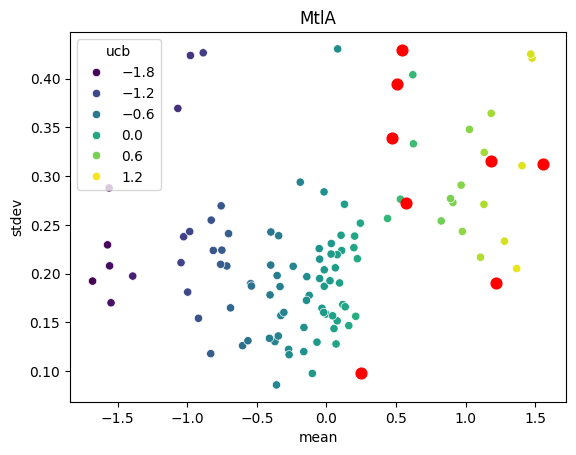

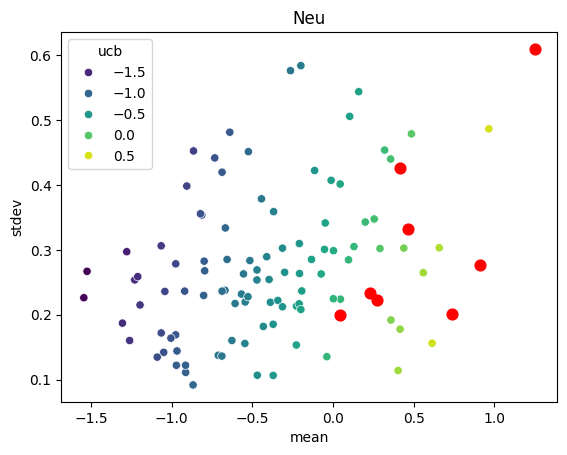

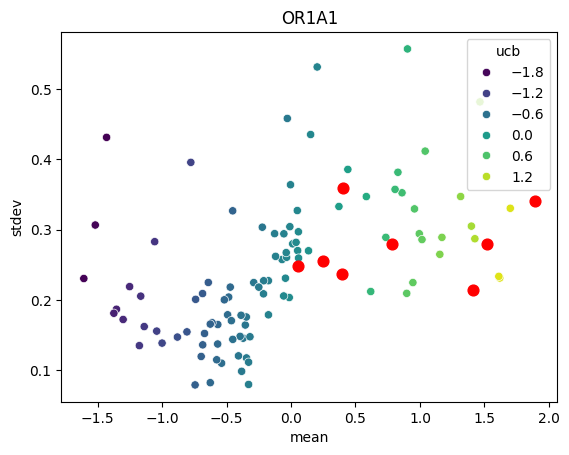

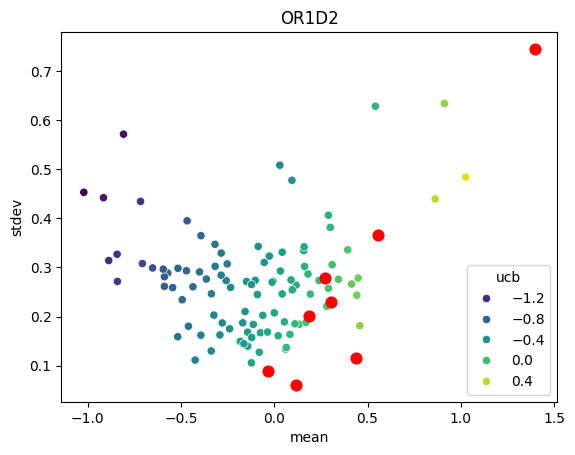

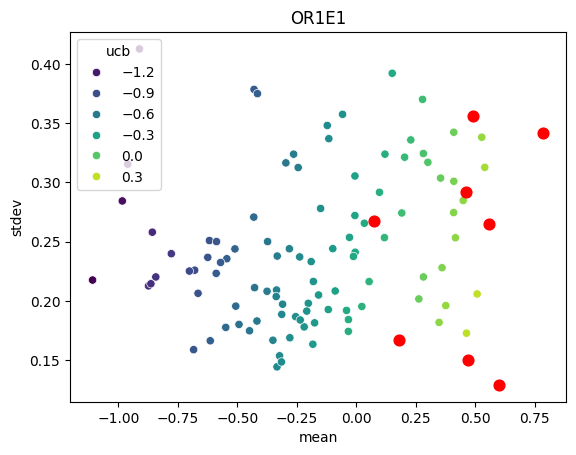

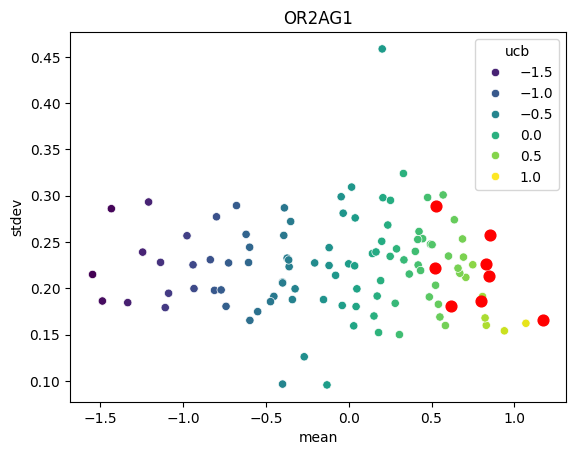

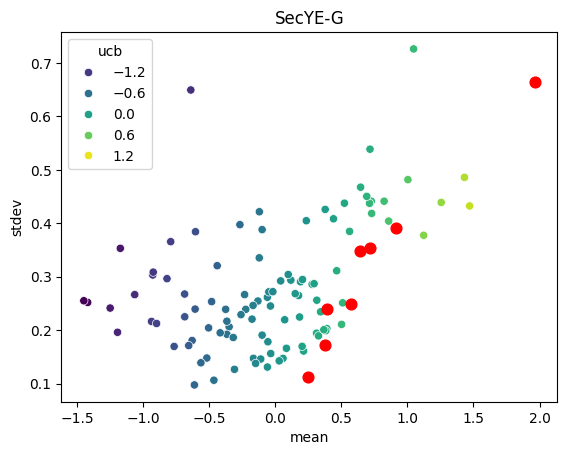

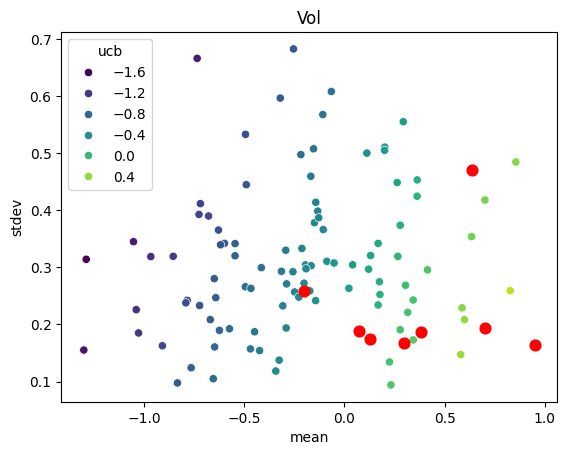

In [10]:
temp = pd.concat([calcs,chosen_rxns[['rxn_id','label']].set_index('rxn_id')],axis=1).fillna('remaining')
for dna,dna_df in temp.groupby('DNA_name'):
    if 'chosen' not in dna_df['label'].unique():
        continue
    sns.scatterplot(data=dna_df,x='mean',y='stdev',hue='ucb',palette='viridis')
    c = dna_df[dna_df['label'] == 'chosen']
    plt.scatter(c['mean'],c['stdev'],s=60,c='red')
    plt.title(dna)
    plt.show()
